# TBX5
[Holt-Oram syndrome](https://omim.org/entry/142900) (HOS) is an autosomal dominant diseasse characterized by  congenital heart defects (CHD), with or without rhythm disturbances and radial defects such as aplasia of the radius or the thumb. HOS is caused by pathogenic variants in the [TBX5](https://omim.org/entry/601620) gene.

Several previous publications have reported candidate genotype-phenotype correlations in HOS.

[Brassington et al. (2003)](https://pubmed.ncbi.nlm.nih.gov/12789647/) stated that

> neither the type of mutation in TBX5 nor the location of a mutation in the T box is predictive of the expressivity of malformations in individuals with HOS.



[Krakow (2013)](https://www.sciencedirect.com/book/9780123838346/emery-and-rimoins-principles-and-practice-of-medical-genetics)  stated

> Defects producing null alleles are predicted to produce both limb and heart defects; however, specific missense mutations produce either significant cardiac defects with minor skeletal anomalies, or the converse.

(I do not have access this this, and apparently this is reference 183 in this chapter)


[Vanlerberghe et al. (2019)](https://pubmed.ncbi.nlm.nih.gov/30552424/) report:

> We observed that isolated septal CHD are more common in the truncating than in the missense variants (p = 0.02). 
> Besides, complex CHD associated to septal defect seems  to be more common in case of missense variants (p = 0.053). 
> Thus, we observed a tendency of less severe CHD in patients with truncating variants compared to the patients with missense variants. 
> No significant difference was observed in the type or the severity of upper limb defects between the two groups.


In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.1.dev0


### TBX5
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TBX5.

In [3]:
gene_symbol = 'TBX5'
mane_tx_id = 'NM_181486.4'
mane_protein_id = "NP_852259.1"

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.21'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 156/156 [01:46<00:00,  1.46individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
50,Atrial septal defect
41,Ventricular septal defect
40,Hypoplasia of the radius
36,Triphalangeal thumb
32,Short thumb
32,Absent thumb
30,Abnormal carpal morphology
27,Secundum atrial septal defect
15,Absent radius
14,Cardiac conduction abnormality


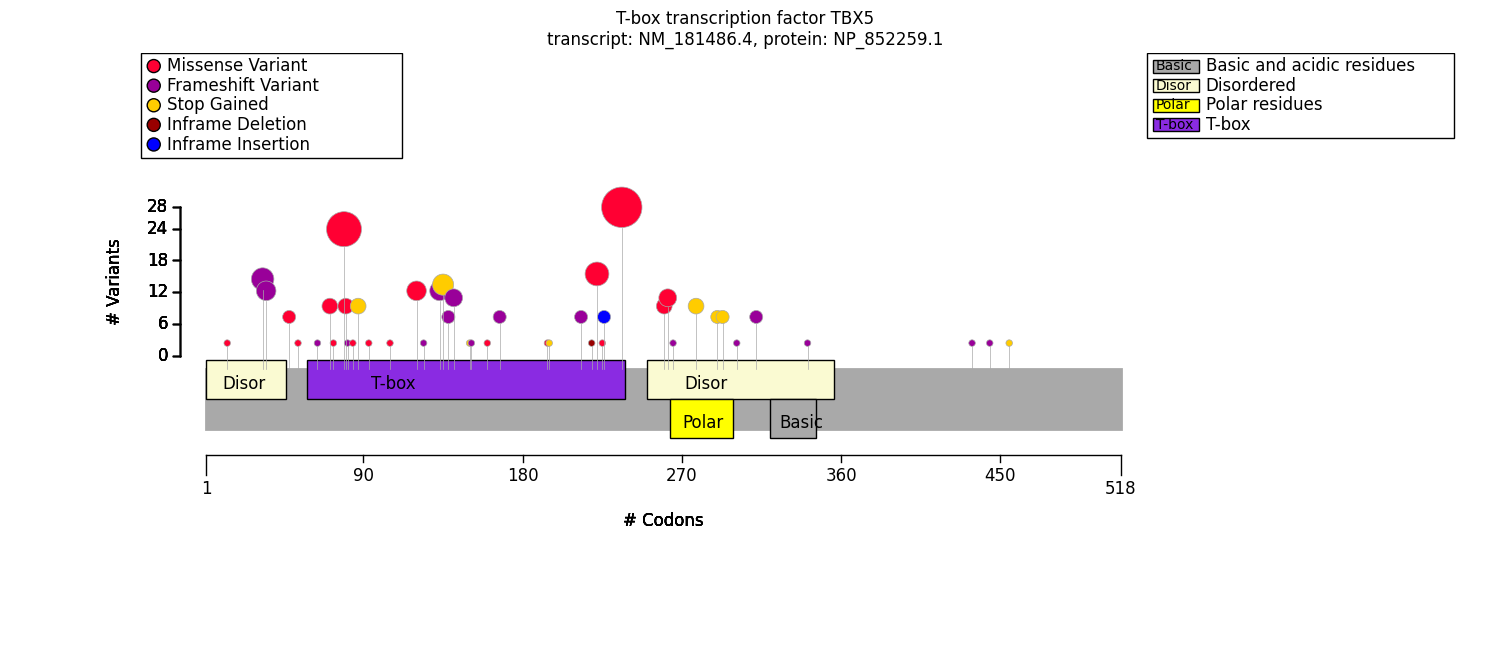

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)



tbx5_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tbx5_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)


Count,Name,Type,Coordinates,Variants
13,Disordered,Region,2 - 46,p.Pro14Thr; p.Ala34ProfsTer32; p.Ser36ThrfsTer25; p.Ala34GlyfsTer27
107,T-box,DNA binding,59 - 238,p.Leu65GlnfsTer10; p.Ser196Ter; p.Thr72Lys; p.Ile106Val; p.Leu94Arg; p.Phe168LeufsTer6; p.Arg237Pro; p.Gly195Ala; p.Met83PhefsTer6; p.Val214GlyfsTer12; p.Gly80Arg; p.Arg237Gln; p.Gln151Ter; p.Thr223Met; p.Trp121Gly; p.Ala143ArgfsTer40; p.Pro85Thr; p.Arg81Trp; p.Lys88Ter; p.Met74Ile; p.Tyr136Ter; p.Arg237Trp; p.Ile227_Glu228insTer; p.Thr161Pro; p.Val153SerfsTer21; p.Lys226Asn; p.Gly125AlafsTer25; p.His220del; p.Pro139GlnfsTer11; p.Arg134ProfsTer49
19,Disordered,Region,251 - 356,p.Gln302ArgfsTer92; p.Glu294Ter; p.Tyr291Ter; p.Val263Met; p.Val267TrpfsTer127; p.Tyr342ThrfsTer52; p.Arg279Ter; p.Gln315ArgfsTer79; p.Ser261Cys
8,Polar residues,Compositional bias,264 - 299,p.Glu294Ter; p.Arg279Ter; p.Tyr291Ter; p.Val267TrpfsTer127
1,Basic and acidic residues,Compositional bias,321 - 346,p.Tyr342ThrfsTer52


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense",
    b_label="other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,16
HMF08,Skipping general term,47
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,288


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Ventricular septal defect [HP:0001629]                31/60     52%  30/30   
Hypoplasia of the radius [HP:0002984]                 30/62     48%  10/27   
Secundum atrial septal defect [HP:0001684]            14/35     40%  13/42   
Atrial septal defect [HP:0001631]                     42/44     95%  41/41   
Abnormal cardiac septum morphology [HP:0001671]       62/62    100%  55/55   
Abnormal hand morphology [HP:0005922]                 53/53    100%  42/42   
Abnormal atrial septum morphology [HP:0011994]        43/43    100%  41/41   
Abnormal cardiac atrium morphology [HP:0005120]       43/43    100%  41/41   
Aplasia/hypoplasia of the extremities [HP:0009815]    55/55    100%  45/45   
Aplasia/hypoplasia involving the skeleton [HP:0...    56/56    100%  47/47   
Aplasia/hypoplasia involving bones of the upper...    55/55    100%  45/45   
Aplasia/hypoplasia involving bones of the extre...    55/55    100%  45/45   
Abnormal appendicular skeleton morphology [HP:0...    64/64    100%  63/63   
Abnormal long bone morphology [HP:0011314]            44/44    100%  19/19   
Aplasia/Hypoplasia of fingers [HP:0006265]            22/22    100%  41/41   
Aplasia/hypoplasia involving bones of the hand ...    22/22    100%  41/41   
Abnormal finger morphology [HP:0001167]               36/36    100%  59/59   
Abnormal digit morphology [HP:0011297]                38/38    100%  62/62   
Abnormal thumb morphology [HP:0001172]                30/30    100%  59/59   

Allele group                                                                   \
                                                   Percent Corrected p values   
Ventricular septal defect [HP:0001629]                100%           0.000009   
Hypoplasia of the radius [HP:0002984]                  37%           1.000000   
Secundum atrial septal defect [HP:0001684]             31%           1.000000   
Atrial septal defect [HP:0001631]                     100%           1.000000   
Abnormal cardiac septum morphology [HP:0001671]       100%           1.000000   
Abnormal hand morphology [HP:0005922]                 100%           1.000000   
Abnormal atrial septum morphology [HP:0011994]        100%           1.000000   
Abnormal cardiac atrium morphology [HP:0005120]       100%           1.000000   
Aplasia/hypoplasia of the extremities [HP:0009815]    100%           1.000000   
Aplasia/hypoplasia involving the skeleton [HP:0...    100%           1.000000   
Aplasia/hypoplasia involving bones of the upper...    100%           1.000000   
Aplasia/hypoplasia involving bones of the extre...    100%           1.000000   
Abnormal appendicular skeleton morphology [HP:0...    100%           1.000000   
Abnormal long bone morphology [HP:0011314]            100%           1.000000   
Aplasia/Hypoplasia of fingers [HP:0006265]            100%           1.000000   
Aplasia/hypoplasia involving bones of the hand ...    100%           1.000000   
Abnormal finger morphology [HP:0001167]               100%           1.000000   
Abnormal digit morphology [HP:0011297]                100%           1.000000   
Abnormal thumb morphology [HP:0001172]                100%           1.000000   

Allele group                                                      
                                                        p values  
Ventricular septal defect [HP:0001629]              4.634415e-07  
Hypoplasia of the radius [HP:0002984]               3.614380e-01  
Secundum atrial septal defect [HP:0001684]          4.756945e-01  
Atrial septal defect [HP:0001631]                   4.946779e-01  
Abnormal cardiac septum morphology [HP:0001671]     1.000000e+00  
Abnormal hand morphology [HP:0005922]               1.000000e+00  
Abnormal atrial septum morphology [HP:0011994]      1.000000e+00  
Abnormal cardiac atrium morphology [HP:0005120]     1.00

# c.710G>A	
This variant, a missense variant, p.Arg237Gln, occurs 22 times in our cohort and is listed as Pathogenic/Likely Pathogenic in [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/variation/7993/).

We need to use the following key (available in the above table): **12_114385521_114385521_C_T**.

In [11]:
from gpsea.analysis.predicate import variant_key

arg237gln = variant_key("12_114385521_114385521_C_T") #	c.710G>A	p.Arg237Gln	

arg237gln_predicate = monoallelic_classifier(
    a_predicate=arg237gln,
    b_predicate=~arg237gln,
    a_label="Arg237Gln",
    b_label="other"
)

arg237gln_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg237gln_predicate,
    pheno_clfs=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=arg237gln_result)

Allele group                                       Arg237Gln            other  \
                                                       Count Percent    Count   
Ventricular septal defect [HP:0001629]                  0/17      0%    61/73   
Atrial septal defect [HP:0001631]                       9/10     90%    74/75   
Hypoplasia of the radius [HP:0002984]                   8/14     57%    32/75   
Secundum atrial septal defect [HP:0001684]               2/4     50%    25/73   
Abnormal cardiac septum morphology [HP:0001671]          9/9    100%  108/108   
Abnormal hand morphology [HP:0005922]                  12/12    100%    83/83   
Abnormal atrial septum morphology [HP:0011994]           9/9    100%    75/75   
Abnormal cardiac atrium morphology [HP:0005120]          9/9    100%    75/75   
Aplasia/hypoplasia of the extremities [HP:0009815]     15/15    100%    85/85   
Aplasia/hypoplasia involving the skeleton [HP:0...     15/15    100%    88/88   
Aplasia/hypoplasia involving bones of the upper...     15/15    100%    85/85   
Aplasia/hypoplasia involving bones of the extre...     15/15    100%    85/85   
Abnormal appendicular skeleton morphology [HP:0...     17/17    100%  110/110   
Abnormal long bone morphology [HP:0011314]             15/15    100%    48/48   
Aplasia/Hypoplasia of fingers [HP:0006265]               2/2    100%    61/61   
Aplasia/hypoplasia involving bones of the hand ...       2/2    100%    61/61   
Abnormal finger morphology [HP:0001167]                  4/4    100%    91/91   
Abnormal digit morphology [HP:0011297]                   4/4    100%    96/96   
Abnormal thumb morphology [HP:0001172]                   4/4    100%    85/85   

Allele group                                                                   \
                                                   Percent Corrected p values   
Ventricular septal defect [HP:0001629]                 84%       1.055209e-09   
Atrial septal defect [HP:0001631]                      99%       1.000000e+00   
Hypoplasia of the radius [HP:0002984]                  43%       1.000000e+00   
Secundum atrial septal defect [HP:0001684]             34%       1.000000e+00   
Abnormal cardiac septum morphology [HP:0001671]       100%       1.000000e+00   
Abnormal hand morphology [HP:0005922]                 100%       1.000000e+00   
Abnormal atrial septum morphology [HP:0011994]        100%       1.000000e+00   
Abnormal cardiac atrium morphology [HP:0005120]       100%       1.000000e+00   
Aplasia/hypoplasia of the extremities [HP:0009815]    100%       1.000000e+00   
Aplasia/hypoplasia involving the skeleton [HP:0...    100%       1.000000e+00   
Aplasia/hypoplasia involving bones of the upper...    100%       1.000000e+00   
Aplasia/hypoplasia involving bones of the extre...    100%       1.000000e+00   
Abnormal appendicular skeleton morphology [HP:0...    100%       1.000000e+00   
Abnormal long bone morphology [HP:0011314]            100%       1.000000e+00   
Aplasia/Hypoplasia of fingers [HP:0006265]            100%       1.000000e+00   
Aplasia/hypoplasia involving bones of the hand ...    100%       1.000000e+00   
Abnormal finger morphology [HP:0001167]               100%       1.000000e+00   
Abnormal digit morphology [HP:0011297]                100%       1.000000e+00   
Abnormal thumb morphology [HP:0001172]                100%       1.000000e+00   

Allele group                                                      
                                                        p values  
Ventricular septal defect [HP:0001629]              5.553731e-11  
Atrial septal defect [HP:0001631]                   2.226891e-01  
Hypoplasia of the radius [HP:0002984]               3.862696e-01  
Secundum atrial septal defect [HP:0001684]          6.089487e-01  
Abnormal cardiac septum morphology [HP:0001671]     1.000000e+00  
Abnormal hand morphology [HP:0005922]               1.000000e+00  
Abnormal atrial septum morphology [HP:0011994]      1.000000

# c.238G>A
This variant, also a missense variant, p.Gly80Arg, was observed 20 times in our cohort. It is listed as Pathogenic in [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/variation/7994/).

In [12]:
gly80arg = variant_key("12_114401830_114401830_C_T") # 		c.238G>A	p.Gly80Arg


gly80arg_predicate = monoallelic_classifier(
    a_predicate=gly80arg,
    b_predicate=~gly80arg,
    a_label="Gly80Arg",
    b_label="other"
)

gly80arg_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gly80arg_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=gly80arg_result)

Allele group                                       Gly80Arg            other  \
                                                      Count Percent    Count   
Atrial septal defect [HP:0001631]                       7/8     88%    76/77   
Ventricular septal defect [HP:0001629]                13/20     65%    48/70   
Abnormal cardiac septum morphology [HP:0001671]       17/17    100%  100/100   
Abnormal hand morphology [HP:0005922]                 18/18    100%    77/77   
Abnormal atrial septum morphology [HP:0011994]          7/7    100%    77/77   
Abnormal cardiac atrium morphology [HP:0005120]         7/7    100%    77/77   
Hypoplasia of the radius [HP:0002984]                  9/19     47%    31/70   
Aplasia/hypoplasia of the extremities [HP:0009815]    10/10    100%    90/90   
Aplasia/hypoplasia involving the skeleton [HP:0...    10/10    100%    93/93   
Aplasia/hypoplasia involving bones of the upper...    10/10    100%    90/90   
Aplasia/hypoplasia involving bones of the extre...    10/10    100%    90/90   
Abnormal appendicular skeleton morphology [HP:0...    12/12    100%  115/115   
Abnormal long bone morphology [HP:0011314]              9/9    100%    54/54   
Aplasia/Hypoplasia of fingers [HP:0006265]              1/1    100%    62/62   
Aplasia/hypoplasia involving bones of the hand ...      1/1    100%    62/62   
Abnormal finger morphology [HP:0001167]                 4/4    100%    91/91   
Abnormal digit morphology [HP:0011297]                  4/4    100%    96/96   
Abnormal thumb morphology [HP:0001172]                  4/4    100%    85/85   

Allele group                                                                   \
                                                   Percent Corrected p values   
Atrial septal defect [HP:0001631]                      99%                1.0   
Ventricular septal defect [HP:0001629]                 69%                1.0   
Abnormal cardiac septum morphology [HP:0001671]       100%                1.0   
Abnormal hand morphology [HP:0005922]                 100%                1.0   
Abnormal atrial septum morphology [HP:0011994]        100%                1.0   
Abnormal cardiac atrium morphology [HP:0005120]       100%                1.0   
Hypoplasia of the radius [HP:0002984]                  44%                1.0   
Aplasia/hypoplasia of the extremities [HP:0009815]    100%                1.0   
Aplasia/hypoplasia involving the skeleton [HP:0...    100%                1.0   
Aplasia/hypoplasia involving bones of the upper...    100%                1.0   
Aplasia/hypoplasia involving bones of the extre...    100%                1.0   
Abnormal appendicular skeleton morphology [HP:0...    100%                1.0   
Abnormal long bone morphology [HP:0011314]            100%                1.0   
Aplasia/Hypoplasia of fingers [HP:0006265]            100%                1.0   
Aplasia/hypoplasia involving bones of the hand ...    100%                1.0   
Abnormal finger morphology [HP:0001167]               100%                1.0   
Abnormal digit morphology [HP:0011297]                100%                1.0   
Abnormal thumb morphology [HP:0001172]                100%                1.0   

Allele group                                                  
                                                    p values  
Atrial septal defect [HP:0001631]                   0.180392  
Ventricular septal defect [HP:0001629]              0.790234  
Abnormal cardiac septum morphology [HP:0001671]     1.000000  
Abnormal hand morphology [HP:0005922]               1.000000  
Abnormal atrial septum morphology [HP:0011994]      1.000000  
Abnormal cardiac atrium morphology [HP:0005120]     1.000000  
Hypoplasia of the radius [HP:0002984]               1.000000  
Aplasia/hypoplasia of the extremities [HP:0009815]  1.000000  
Aplasia/hypoplasia involving the skeleton [HP:0...  1.000000  
Aplasia/hypoplasia involving bones of the upper...  1.000000  
Aplasia/hypoplasia inv

In [13]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Ventricular septal defect [HP:0001629]              17/34     50%  17/29   
Abnormal cardiac septum morphology [HP:0001671]     36/36    100%  35/35   
Abnormal hand morphology [HP:0005922]               34/34    100%  30/30   
Aplasia/hypoplasia involving the skeleton [HP:0...  35/35    100%  28/28   
Abnormal appendicular skeleton morphology [HP:0...  46/46    100%  34/34   

Sex                                                                            \
                                                   Percent Corrected p values   
Ventricular septal defect [HP:0001629]                 59%                1.0   
Abnormal cardiac septum morphology [HP:0001671]       100%                1.0   
Abnormal hand morphology [HP:0005922]                 100%                1.0   
Aplasia/hypoplasia involving the skeleton [HP:0...    100%                1.0   
Abnormal appendicular skeleton morphology [HP:0...    100%                1.0   

Sex                                                           
                                                    p values  
Ventricular septal defect [HP:0001629]              0.613546  
Abnormal cardiac septum morphology [HP:0001671]     1.000000  
Abnormal hand morphology [HP:0005922]               1.000000  
Aplasia/hypoplasia involving the skeleton [HP:0...  1.000000  
Abnormal appendicular skeleton morphology [HP:0...  1.000000

# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=arg237gln_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=gly80arg_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    )
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=tbx5_fig)

Figure saved to ../../supplement/img/TBX5_protein_diagram-draft.pdf
Output to ../../supplement/tex/TBX5_summary_draft.tex
